In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
from pandas.plotting import scatter_matrix
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import scipy as sp
from itertools import chain
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
import statsmodels.stats.weightstats
from matplotlib import path
import matplotlib
from scipy.stats import probplot,shapiro, sem
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import cm
from numpy import linspace
import umap.umap_ as umap
#import pylab
import os
#import PIL
#from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')

    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%100000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    


In [3]:
def RSA_Rs_protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [4]:
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= r'$R_g\left/R_g^{theta}\right.$' 
    y_variable=r'$R_s$'
    global grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]

    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean
    
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)
    
    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein['Rg/Rg_theta'].values)
        y_total.append(temp_protein.ratio.values)

        # fC_value=RSA_based_fC(temp_protein,
        #                protein_label,
        #                second_obj,testeq_GW,
        #                temp_protein.shape[0],
        #                1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['Rg/Rg_mean'].max()>max_x_val or testeq_GW['Rg/Rg_mean'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    # axTemperature.text(0.7,0.8,
    #                    '$f_C$= '+format(fC_value,'0.3f'),
    #                   transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



# generate a dataframe connecting directory with seq_name in their property df

In [5]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')

In [6]:
%%time
seq_name_list = []
seq_name_dir = []
protein_name = []
for root, dirs, files in os.walk('IDROME_larsen/IDRome_v4/', topdown=False):
    for name in files:
        seq_name_list.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]+['_']+[root.split('/')[len(root.split('/'))-1]]))
        protein_name.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]))
        seq_name_dir.append(root)
        break
seq_name_dir_df = pd.DataFrame(zip(seq_name_list,seq_name_dir,protein_name),columns=['seq_name','seq_dir','protein_uniprot_id'])
del seq_name_list, seq_name_dir, protein_name
seq_name_dir_df

CPU times: user 222 ms, sys: 1.07 s, total: 1.3 s
Wall time: 1.92 s


,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


# write function

In [7]:
def compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    protein_rg_theta = seq_name_AFRC[seq_name_AFRC.seq_name==seq_name].AFRC_mean_rg_theta.values[0]
    #convert nm to angstrom for lindorff-larsen data
    protein_rg_by_rg_theta = (np.load(f'{example_protein_dir}/rg.npy')*10)/protein_rg_theta
    protein_df = pd.DataFrame(zip(np.load(f'{example_protein_dir}/rg.npy')**2,
                                 protein_rg_by_rg_theta),columns=['Rg2','Rg/Rg_theta']).copy()
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [8]:
def RSA_Rs_compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return RSA_Rs_protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [9]:
def load_trajectory(seq_name):
    #https://soursop.readthedocs.io/en/latest/usage/overview.html
    from soursop.sstrajectory import SSTrajectory
    global t_md, t_soursop,ree
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t_md = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_soursop = SSTrajectory(f'{example_protein_dir}/traj.xtc',f'{example_protein_dir}/top.pdb')
    ree = np.load(f'{example_protein_dir}/ete.npy')
    ProtObj = t_soursop.proteinTrajectoryList[0]
    return 

In [10]:
#master_df = master_df.reset_index(drop=True).copy()

# use  pyconformap shape vs size

In [11]:
exec(open("pyconformap_modified.py").read())
def generate_2d_map(seq_name):
    location_of_files = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]    
    rg2_value = np.load(location_of_files+'/rg.npy')**2
    ree2_value = np.load(location_of_files+'/ete.npy')**2
    pd.DataFrame(zip(rg2_value,ree2_value),columns=['Rg2','Ree2']).to_csv(seq_name+'.csv',index=False)
    map_2d_seq_name = PyConforMap(seq_name+'.csv')
    map_2d_seq_name.plot_protein_against_GW(seq_name+'.csv')
    os.remove(seq_name+'.csv')
    return 

# combine the df


In [34]:
seq_name_fluctations = pd.read_csv('HPC_computed_fC_values_all.csv').set_index('seq_name_list')
# the bounded_frac_size_shape is only for size-shape (through pyconformap_modified)


#add fP to the property df
seq_name_AFRC['fP'] = [seq.count('P')/len(seq) for seq in seq_name_AFRC.fasta.values]

idrome_prop_flucs = pd.concat([seq_name_AFRC.set_index('seq_name'),
           seq_name_fluctations[['fC_shape_shape',
                                 'fA_shape_shape',
                                 'fC_size_shape',
                                 'fA_size_shape',
                                 'bounded_frac_size_shape']]],
          axis=1).reset_index().rename(columns={'index':'seq_name'}).copy()

del seq_name_fluctations, seq_name_AFRC
idrome_prop_flucs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,AFRC_mean_rg_theta,rg_rg_theta_mean,mean_inst_ratio,mean_RSA,fP,fC_shape_shape,fA_shape_shape,fC_size_shape,fA_size_shape,bounded_frac_size_shape
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,15.191941,1.057621,5.808555,0.442952,0.108108,0.824935,0.421875,0.763794,0.271084,1.0
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,14.102458,1.026155,5.598546,0.408551,0.031250,0.843392,0.441406,0.788809,0.277108,1.0
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,20.524202,1.094369,5.764964,0.403545,0.044776,0.835675,0.472656,0.804982,0.307229,1.0
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,28.732651,1.057445,5.766837,0.365432,0.060606,0.837388,0.511719,0.813702,0.391566,1.0
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,17.085913,1.100872,6.130355,0.438200,0.108696,0.821242,0.472656,0.780469,0.283133,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,33.590806,1.128366,5.388851,0.391268,0.093923,0.853953,0.496094,0.803989,0.385542,1.0
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,39.658059,1.156510,5.803936,0.394400,0.055118,0.846289,0.531250,0.828744,0.415663,1.0
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,25.880343,1.164103,5.738483,0.426205,0.064220,0.854581,0.484375,0.811823,0.361446,1.0
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,26.561695,1.108354,5.813349,0.400844,0.017699,0.841062,0.507812,0.811157,0.367470,1.0


KeyError: 'A3KN83_666_850'

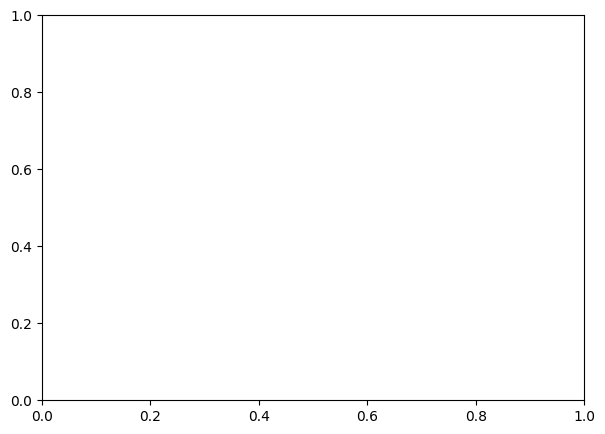

In [20]:

fig,ax = plt.subplots(figsize=(7,5))


sc = ax.scatter(seq_name_AFRC['z_delta_+-'],
           seq_name_AFRC['mean_RSA'],s=20,alpha=0.7)
               
           

ax.set_xlabel('z_delta_+-')
ax.set_ylabel('<RSA>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)


In [10]:
seq_name_AFRC.select_dtypes(include='number').corr(method='pearson')[['mean_inst_ratio','ete2_Rg2','mean_RSA']]


,mean_inst_ratio,ete2_Rg2,mean_RSA
N,-0.301564,-0.347066,-0.374355
nu,0.770997,0.808390,0.873747
SPR,0.420789,0.472647,0.678968
ete2_Rg2,0.980125,1.000000,0.567718
S,0.220732,0.291161,0.734985
Delta,0.268018,0.317931,0.687171
Rg/nm,-0.310880,-0.363259,-0.363609
Ree/nm,-0.261774,-0.315605,-0.338933
Rh/nm,-0.324065,-0.377658,-0.398231
fK,0.037050,0.032960,0.055004


In [183]:
df_temp = seq_name_AFRC[['nu','rg_rg_theta_mean','mean_inst_ratio','ete2_Rg2','mean_RSA']].copy()
df_temp = df_temp.rename(columns= {'rg_rg_theta_mean':r'<$R_g\left/R_g^{theta}\right.$>','mean_inst_ratio': r'<$R_{ee}^{2}/R_g^{2}$>',
                        'ete2_Rg2':r'<$R_{ee}^{2}>/<R_g^{2}$>','mean_RSA':'<RSA>'}).copy()
df_temp.corr(method='pearson')
#x_variable= r'$R_g\left/R_g^{theta}\right.$' 
del df_temp

,nu,<$R_g\left/R_g^{theta}\right.$>,<$R_{ee}^{2}/R_g^{2}$>,<$R_{ee}^{2}>/<R_g^{2}$>,<RSA>
nu,1.000000,0.327936,0.770997,0.808390,0.873747
<$R_g\left/R_g^{theta}\right.$>,0.327936,1.000000,0.120879,0.102732,0.405337
<$R_{ee}^{2}/R_g^{2}$>,0.770997,0.120879,1.000000,0.980125,0.531939
<$R_{ee}^{2}>/<R_g^{2}$>,0.808390,0.102732,0.980125,1.000000,0.567718
<RSA>,0.873747,0.405337,0.531939,0.567718,1.000000


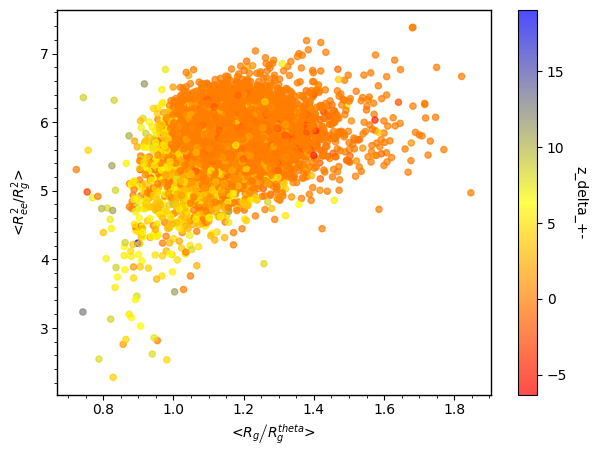

In [61]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('rainbow')

sc = ax.scatter(seq_name_AFRC['rg_rg_theta_mean'],
           seq_name_AFRC['mean_inst_ratio'],s=20,c=seq_name_AFRC['z_delta_+-'].values,alpha=0.7,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('z_delta_+-',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)


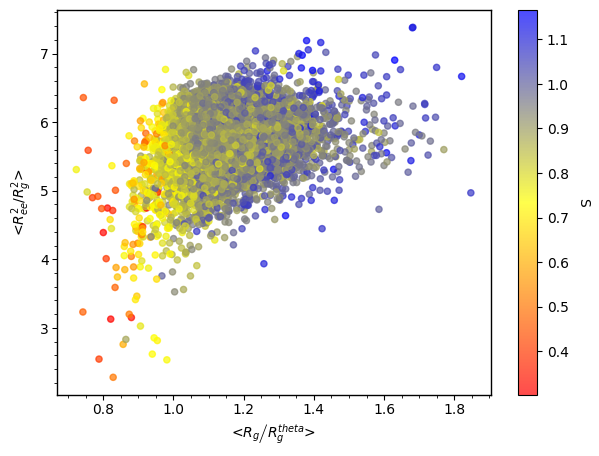

In [29]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('rainbow')

sc = ax.scatter(seq_name_AFRC['rg_rg_theta_mean'],
           seq_name_AFRC['mean_inst_ratio'],s=20,c=seq_name_AFRC['S'].values,alpha=0.7,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('S',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)


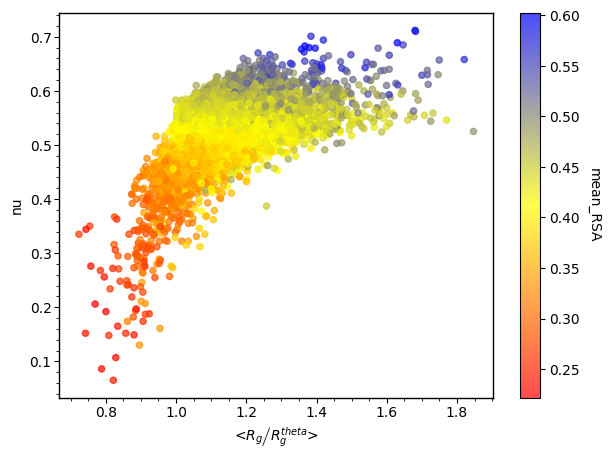

In [53]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('rainbow')

sc = ax.scatter(seq_name_AFRC['rg_rg_theta_mean'],
           seq_name_AFRC['nu'],s=20,c=seq_name_AFRC['mean_RSA'].values,alpha=0.7,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('mean_RSA',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel('nu')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)


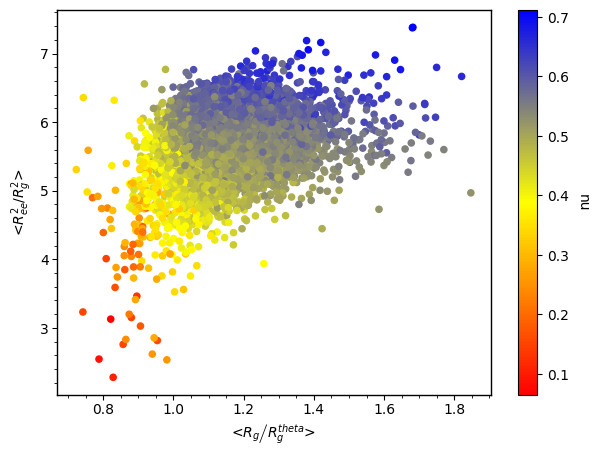

In [124]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(seq_name_AFRC['rg_rg_theta_mean'],
           seq_name_AFRC['mean_inst_ratio'],s=20,c=seq_name_AFRC['nu'].values,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('nu',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

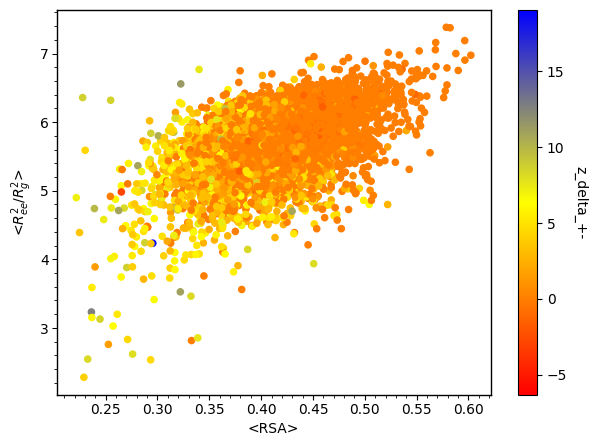

In [31]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('rainbow')
sc = ax.scatter(seq_name_AFRC['mean_RSA'],
           seq_name_AFRC['mean_inst_ratio'],s=20,c=seq_name_AFRC['z_delta_+-'].values,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('z_delta_+-',rotation=270,labelpad=15)

ax.set_xlabel('<RSA>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

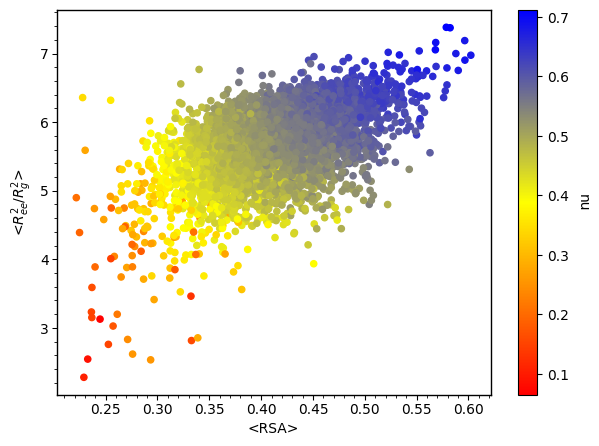

In [123]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('rainbow')
sc = ax.scatter(seq_name_AFRC['mean_RSA'],
           seq_name_AFRC['mean_inst_ratio'],s=20,c=seq_name_AFRC['nu'].values,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('nu',rotation=270,labelpad=15)

ax.set_xlabel('<RSA>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

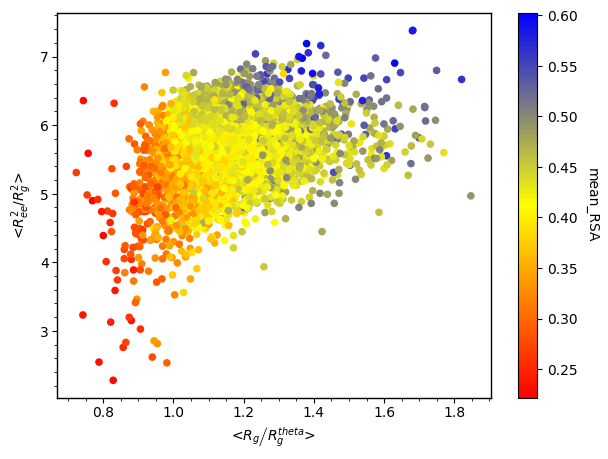

In [122]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(seq_name_AFRC['rg_rg_theta_mean'],
           seq_name_AFRC['mean_inst_ratio'],s=20,c=seq_name_AFRC['mean_RSA'].values,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('mean_RSA',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

# some odd protein specific examples

In [155]:
seq_name_AFRC[seq_name_AFRC.mean_inst_ratio==seq_name_AFRC.mean_inst_ratio.min()]

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,z_omega_+,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr,AFRC_mean_rg_theta,rg_rg_theta_mean,mean_inst_ratio,mean_RSA
18874,Q8WTT2_1_202,Q8WTT2,202,0.107,10.082064,2.377026,0.5068,0.131237,2.954646,4.04748,...,1.657685,2.536864,-0.504585,0.0,0.213,9.981,35.652473,0.828463,2.278248,0.228992


In [156]:
seq_name_AFRC[seq_name_AFRC.seq_name=='Q86SE8_129_214'].fasta.values[0]

'EEEEEEEGEEEEEEEEDDEDEDADISLEEQSPVKQVKRLVPQKQASVAKKKKLEKEEEEIRASVRDKSPVKKAKATARAKKPGFKK'

In [122]:
load_trajectory('Q8WTT2_1_202')

In [152]:
from itertools import combinations
for i in combinations(range(0,201,1),2):
    print(i)

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(0, 21)
(0, 22)
(0, 23)
(0, 24)
(0, 25)
(0, 26)
(0, 27)
(0, 28)
(0, 29)
(0, 30)
(0, 31)
(0, 32)
(0, 33)
(0, 34)
(0, 35)
(0, 36)
(0, 37)
(0, 38)
(0, 39)
(0, 40)
(0, 41)
(0, 42)
(0, 43)
(0, 44)
(0, 45)
(0, 46)
(0, 47)
(0, 48)
(0, 49)
(0, 50)
(0, 51)
(0, 52)
(0, 53)
(0, 54)
(0, 55)
(0, 56)
(0, 57)
(0, 58)
(0, 59)
(0, 60)
(0, 61)
(0, 62)
(0, 63)
(0, 64)
(0, 65)
(0, 66)
(0, 67)
(0, 68)
(0, 69)
(0, 70)
(0, 71)
(0, 72)
(0, 73)
(0, 74)
(0, 75)
(0, 76)
(0, 77)
(0, 78)
(0, 79)
(0, 80)
(0, 81)
(0, 82)
(0, 83)
(0, 84)
(0, 85)
(0, 86)
(0, 87)
(0, 88)
(0, 89)
(0, 90)
(0, 91)
(0, 92)
(0, 93)
(0, 94)
(0, 95)
(0, 96)
(0, 97)
(0, 98)
(0, 99)
(0, 100)
(0, 101)
(0, 102)
(0, 103)
(0, 104)
(0, 105)
(0, 106)
(0, 107)
(0, 108)
(0, 109)
(0, 110)
(0, 111)
(0, 112)
(0, 113)
(0, 114)
(0, 115)
(0, 116)
(0, 117)
(0, 118)
(0, 119)
(0, 120)
(0, 121)
(0, 122)
(0, 123)
(

In [147]:

pr.get_inter_residue_COM_distance(0, 201)[10:]

array([ 15.56601699,  31.69254008,  51.52185187,  37.69816104,
        53.99132641,  47.69785836,  42.52478025,  21.63614341,
        15.87156508,  23.76872625,  53.05278564,  50.47194607,
        54.19231358,  36.57354331,  69.48235141,  36.34267288,
        40.99159046,  82.5497195 ,  65.61910049,  46.90721089,
        74.74010821,  59.03356174,  31.5836972 ,  27.73157586,
        23.19252553,  39.91963655,  36.48131782,  60.30027992,
        75.78227133,  24.58416902,  87.14598656,  85.47175117,
        46.53443221,  43.3820195 ,  74.11443944,  56.28679995,
        20.26206797,  37.98062647,  18.66744845,  54.93567869,
        56.82982814,  45.62370073,  14.8570687 ,  30.75632734,
        31.70624091,  40.87604902,  68.40554448,  58.6203306 ,
        59.62576899,  59.81343852,  37.60599382,  48.59608658,
        39.74622338,  69.22885279,  46.86071771,  42.7256847 ,
        58.27945455,  44.91036904,  18.46287346,  18.75831101,
        24.02222138,  39.51805764,  23.32068235,  20.18

In [126]:
ree*10

array([ 15.566017 ,  31.69254  ,  51.521854 ,  37.698162 ,  53.991325 ,
        47.69786  ,  42.52478  ,  21.636143 ,  15.871565 ,  23.768728 ,
        53.052788 ,  50.471947 ,  54.192314 ,  36.573544 ,  69.48235  ,
        36.342674 ,  40.99159  ,  82.54971  ,  65.6191   ,  46.90721  ,
        74.74011  ,  59.03356  ,  31.583694 ,  27.731575 ,  23.192524 ,
        39.919636 ,  36.481316 ,  60.300278 ,  75.78227  ,  24.58417  ,
        87.14599  ,  85.471756 ,  46.53443  ,  43.38202  ,  74.11444  ,
        56.286804 ,  20.262068 ,  37.980625 ,  18.667448 ,  54.93568  ,
        56.82983  ,  45.623703 ,  14.857069 ,  30.756329 ,  31.70624  ,
        40.87605  ,  68.40555  ,  58.620335 ,  59.625774 ,  59.81344  ,
        37.605995 ,  48.596085 ,  39.746223 ,  69.22885  ,  46.860718 ,
        42.72568  ,  58.279453 ,  44.91037  ,  18.462873 ,  18.758312 ,
        24.02222  ,  39.51806  ,  23.320683 ,  20.18119  ,  28.58961  ,
        13.938985 ,  36.90362  ,  41.481537 ,  35.196068 ,  36.7

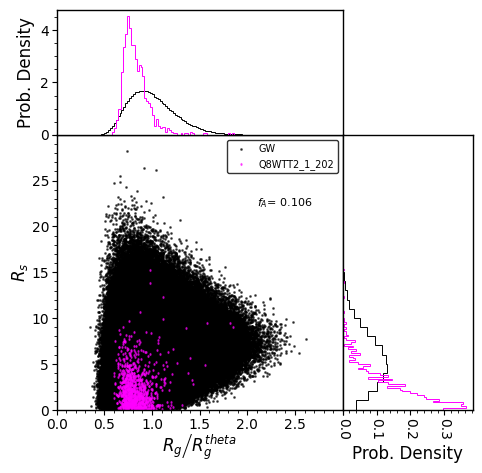

In [136]:
compute_3dplot_from_seq_name('Q8WTT2_1_202')

100000 GW snapshots completed
200000 GW snapshots completed
300000 GW snapshots completed
400000 GW snapshots completed
500000 GW snapshots completed
600000 GW snapshots completed
700000 GW snapshots completed
800000 GW snapshots completed
900000 GW snapshots completed
1000000 GW snapshots completed


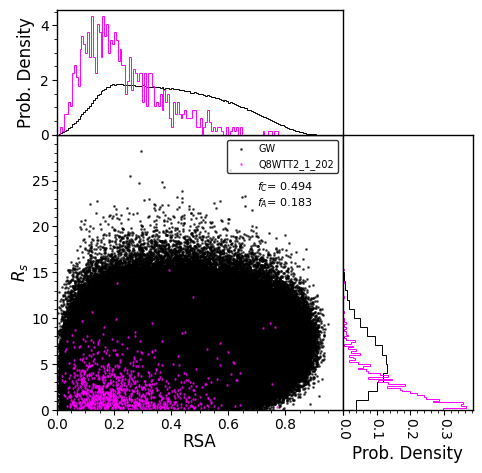

In [137]:
RSA_Rs_compute_3dplot_from_seq_name('Q8WTT2_1_202')

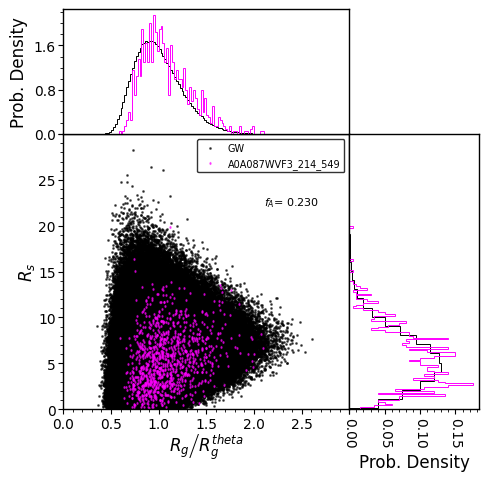

In [64]:
compute_3dplot_from_seq_name('A0A087WVF3_214_549')

100000 GW snapshots completed
200000 GW snapshots completed
300000 GW snapshots completed
400000 GW snapshots completed
500000 GW snapshots completed
600000 GW snapshots completed
700000 GW snapshots completed
800000 GW snapshots completed
900000 GW snapshots completed
1000000 GW snapshots completed


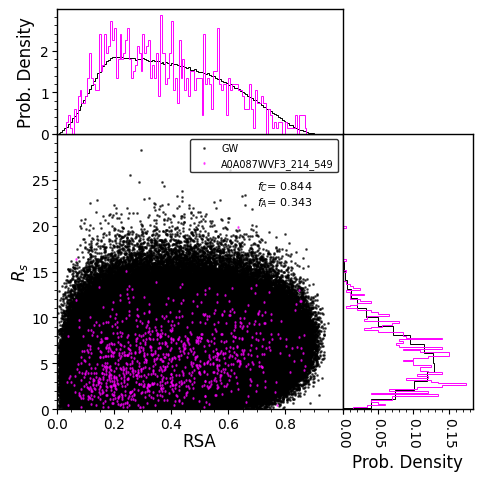

In [65]:
RSA_Rs_compute_3dplot_from_seq_name('A0A087WVF3_214_549')

In [118]:
#new compaction definition?
seq_name_AFRC[((seq_name_AFRC.mean_RSA<0.4) | (seq_name_AFRC.mean_inst_ratio<5.5)) & (seq_name_AFRC.rg_rg_theta_mean<1.05)].sort_values(by='nu')


,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr,AFRC_mean_rg_theta,rg_rg_theta_mean,mean_inst_ratio,mean_RSA,fP
15342,Q86SE8_129_214,Q86SE8,86,0.065,10.260482,3.107066,0.314455,0.113370,1.912174,3.089510,...,10.999018,0.037566,0.000000,0.011,10.023,23.282440,0.821546,3.127037,0.244593,0.046512
11962,Q5JTH9_1043_1297,Q5JTH9,255,0.086,9.929288,2.543884,0.402369,0.116119,3.149610,4.620003,...,6.151640,0.011052,0.000000,0.171,9.974,39.950646,0.788158,2.543836,0.232715,0.054902
18874,Q8WTT2_1_202,Q8WTT2,202,0.107,10.082064,2.377026,0.506800,0.131237,2.954646,4.047480,...,2.536864,-0.504585,0.000000,0.213,9.981,35.652473,0.828463,2.278248,0.228992,0.064356
5960,P26583_163_209,P26583,47,0.130,10.454322,3.622290,0.643660,0.167728,1.529460,2.629455,...,12.443763,0.000000,0.000000,0.420,10.437,17.075374,0.895869,3.461718,0.332301,0.063830
11889,Q5HYW3_413_569,Q5HYW3,157,0.148,10.014163,4.033625,0.398007,0.123606,2.526162,4.687739,...,6.140307,1.238190,0.000000,0.221,9.986,31.216251,0.808556,4.008720,0.255014,0.101911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27220,Q9Y2J0_516_550,Q9Y2J0,35,0.545,10.322823,6.425580,0.881326,0.200132,1.542387,3.730703,...,2.737230,0.523769,0.000000,0.530,10.315,14.773214,1.043052,6.020307,0.391003,0.028571
18558,Q8TD43_826_861,Q8TD43,36,0.545,9.873556,5.978617,0.982446,0.236549,1.525108,3.541551,...,0.000000,-0.539807,0.000000,0.526,10.150,14.841428,1.027481,5.488161,0.400575,0.055556
21195,Q96PV0_362_401,Q96PV0,40,0.554,9.916878,5.760227,0.879680,0.213483,1.620103,3.718281,...,0.000000,0.000000,0.000000,0.527,10.095,15.430812,1.049503,5.366137,0.404315,0.075000
4016,O96011_155_186,O96011,32,0.557,10.062237,5.887375,1.003174,0.236108,1.437441,3.324554,...,0.000000,-0.692120,0.000000,0.531,10.183,13.795756,1.041401,5.407909,0.430604,0.125000


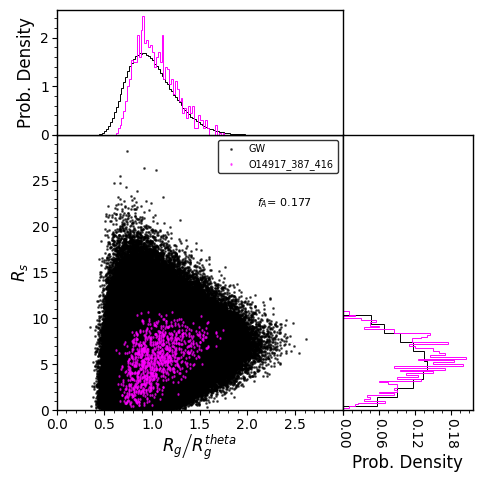

In [116]:
compute_3dplot_from_seq_name('O14917_387_416')

100000 GW snapshots completed
200000 GW snapshots completed
300000 GW snapshots completed
400000 GW snapshots completed
500000 GW snapshots completed
600000 GW snapshots completed
700000 GW snapshots completed
800000 GW snapshots completed
900000 GW snapshots completed
1000000 GW snapshots completed


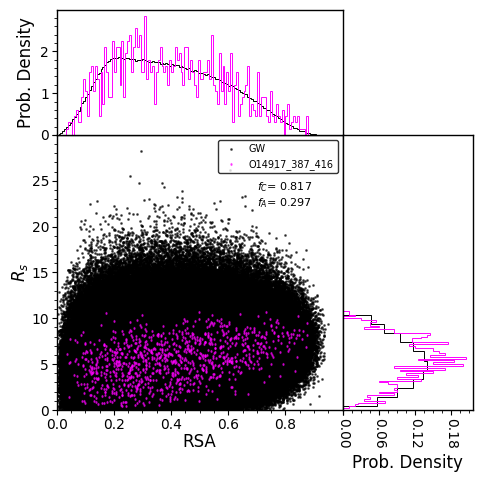

In [117]:
RSA_Rs_compute_3dplot_from_seq_name('O14917_387_416')

In [119]:
seq_name_AFRC[(seq_name_AFRC.mean_RSA>0.4) & (seq_name_AFRC.mean_inst_ratio<4)]

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,z_omega_+,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr,AFRC_mean_rg_theta,rg_rg_theta_mean,mean_inst_ratio,mean_RSA
21282,Q96QF7_1_488,Q96QF7,488,0.387,10.20972,4.171397,1.100252,0.231617,6.943495,13.485668,...,5.916947,4.832233,2.235224,0.0,0.574,10.284,55.419991,1.257642,3.934484,0.450711


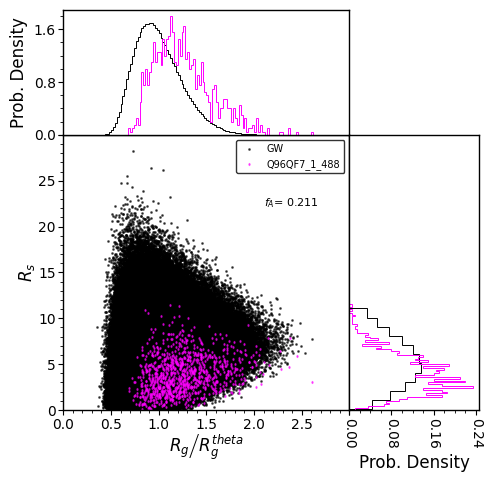

In [120]:
compute_3dplot_from_seq_name('Q96QF7_1_488')

100000 GW snapshots completed
200000 GW snapshots completed
300000 GW snapshots completed
400000 GW snapshots completed
500000 GW snapshots completed
600000 GW snapshots completed
700000 GW snapshots completed
800000 GW snapshots completed
900000 GW snapshots completed
1000000 GW snapshots completed


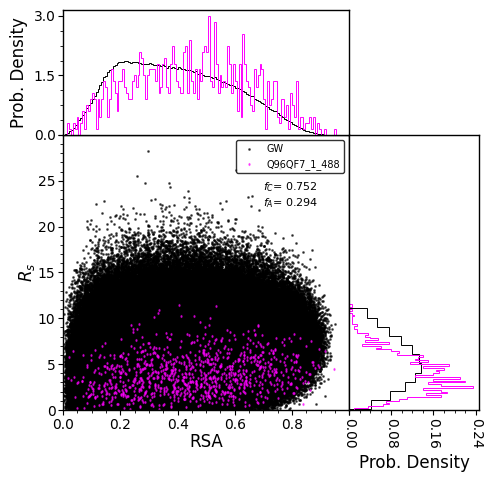

In [11]:
RSA_Rs_compute_3dplot_from_seq_name('Q96QF7_1_488')

In [35]:
seq_name_AFRC[seq_name_AFRC.seq_name=='Q96QF7_1_488'].mean_inst_ratio.values[0]

3.934483542789815

In [29]:
protein_df['Rg'] = protein_df['Rg2']**0.5
protein_df['Rg/Rg_theta'] = (protein_df['Rg']*10)/seq_name_AFRC[seq_name_AFRC.seq_name=='Q96QF7_1_488'].AFRC_mean_rg_theta.values[0]

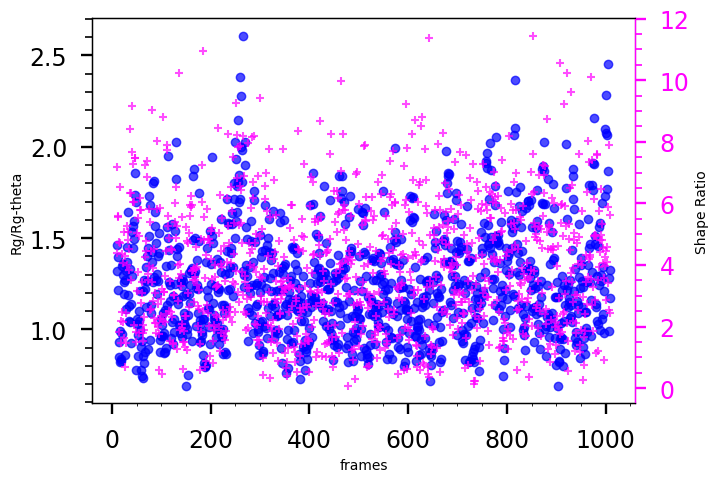

In [64]:



fig,ax = plt.subplots(figsize=(7,5))


ax.scatter(protein_df.index.values,
           protein_df['Rg/Rg_theta'].values,alpha=0.7,color='blue')
ax2 = ax.twinx()               
ax2.scatter(protein_df.index.values,
           protein_df['ratio'].values,alpha=0.7,color='magenta',marker='+')           

ax.set_xlabel('frames')
ax.set_ylabel('Rg/Rg-theta')
ax2.set_ylabel('Shape Ratio')
for i in ['top', 'left', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax2.spines['right'].set_linewidth(1)
ax2.spines['right'].set_color('magenta')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=17, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='y', which='minor', width = 1.2, size = 5)    

ax2.minorticks_on()
ax2.tick_params(axis='both', which='major', labelsize=17, width = 1.7, size = 8,pad=10,colors='magenta')
ax2.tick_params(axis='y', which='minor', width = 1.2, size = 5,colors='magenta')    


In [127]:
seq_name_AFRC[(seq_name_AFRC.rg_rg_theta_mean>1.8) & (seq_name_AFRC.mean_inst_ratio<7)]

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,z_omega_+,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr,AFRC_mean_rg_theta,rg_rg_theta_mean,mean_inst_ratio,mean_RSA
16273,Q8IWN7_1577_2400,Q8IWN7,824,0.525,10.148150,5.322536,1.070733,0.231269,13.205092,29.222946,...,0.0,0.625266,0.0,0.032767,0.546,10.155,71.556119,1.846889,4.968700,0.491508
19507,Q92688_159_251,Q92688,93,0.658,11.054479,6.988278,1.137745,0.268893,4.367992,11.226708,...,0.0,2.002604,0.0,0.000000,0.630,10.851,23.994634,1.820657,6.666685,0.565528


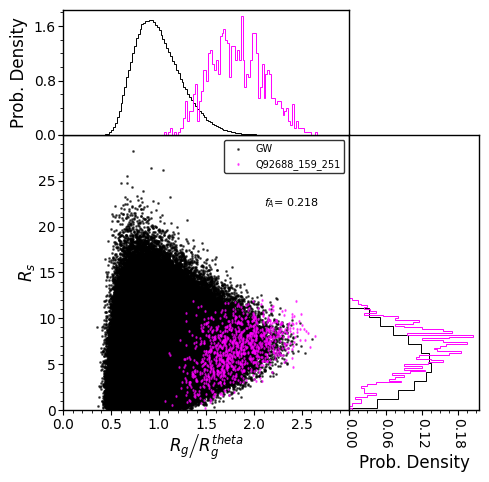

In [128]:
compute_3dplot_from_seq_name('Q92688_159_251')

100000 GW snapshots completed
200000 GW snapshots completed
300000 GW snapshots completed
400000 GW snapshots completed
500000 GW snapshots completed
600000 GW snapshots completed
700000 GW snapshots completed
800000 GW snapshots completed
900000 GW snapshots completed
1000000 GW snapshots completed


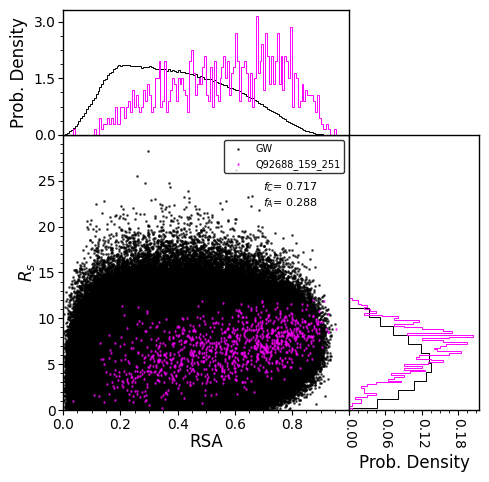

In [129]:
RSA_Rs_compute_3dplot_from_seq_name('Q92688_159_251')

# Examine original compaction definition
## but first lets see what features the original definition shows

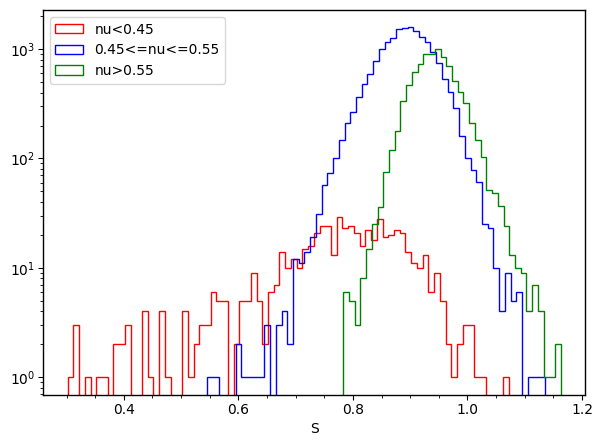

In [99]:

fig,ax = plt.subplots(figsize=(7,5))


ax.hist(seq_name_AFRC[seq_name_AFRC['nu']<0.45]['S'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[seq_name_AFRC['nu']<0.45]['S'].min(),
                           seq_name_AFRC[seq_name_AFRC['nu']<0.45]['S'].max(),0.01),color='red',label='nu<0.45')
               
ax.hist(seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['S'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['S'].min(),
                           seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['S'].max(),0.01),
        color='blue',label='0.45<=nu<=0.55')

ax.hist(seq_name_AFRC[seq_name_AFRC['nu']>0.55]['S'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[seq_name_AFRC['nu']>0.55]['S'].min(),
                           seq_name_AFRC[seq_name_AFRC['nu']>0.55]['S'].max(),0.01),color='green',label='nu>0.55')

ax.set_xlabel('S')

ax.legend()
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.set_yscale('log')
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)


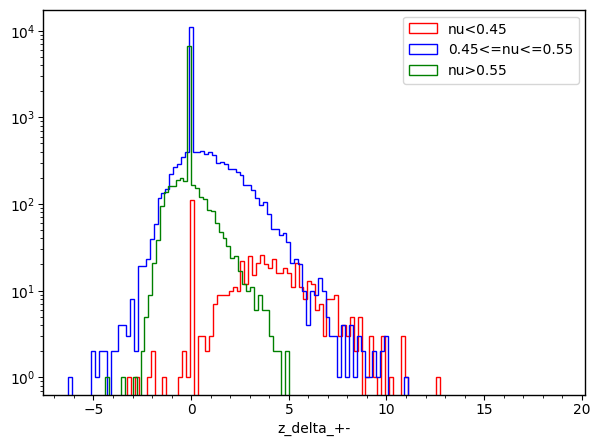

In [85]:

fig,ax = plt.subplots(figsize=(7,5))


ax.hist(seq_name_AFRC[seq_name_AFRC['nu']<0.45]['z_delta_+-'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[seq_name_AFRC['nu']<0.45]['z_delta_+-'].min(),
                           seq_name_AFRC[seq_name_AFRC['nu']<0.45]['z_delta_+-'].max(),0.2),color='red',label='nu<0.45')
               
ax.hist(seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['z_delta_+-'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['z_delta_+-'].min(),
                           seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['z_delta_+-'].max(),0.2),
        color='blue',label='0.45<=nu<=0.55')

ax.hist(seq_name_AFRC[seq_name_AFRC['nu']>0.55]['z_delta_+-'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[seq_name_AFRC['nu']>0.55]['z_delta_+-'].min(),
                           seq_name_AFRC[seq_name_AFRC['nu']>0.55]['z_delta_+-'].max(),0.2),color='green',label='nu>0.55')

ax.set_xlabel('z_delta_+-')

ax.legend()
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.set_yscale('log')
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)


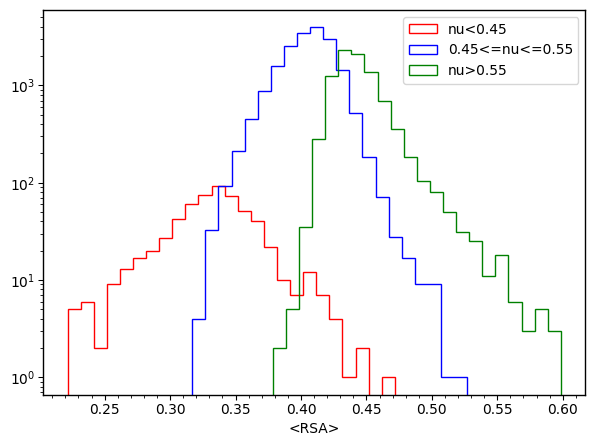

In [92]:

fig,ax = plt.subplots(figsize=(7,5))


ax.hist(seq_name_AFRC[seq_name_AFRC['nu']<0.45]['mean_RSA'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[seq_name_AFRC['nu']<0.45]['mean_RSA'].min(),
                           seq_name_AFRC[seq_name_AFRC['nu']<0.45]['mean_RSA'].max(),0.01),color='red',label='nu<0.45')
               
ax.hist(seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['mean_RSA'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['mean_RSA'].min(),
                           seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['mean_RSA'].max(),0.01),
        color='blue',label='0.45<=nu<=0.55')

ax.hist(seq_name_AFRC[seq_name_AFRC['nu']>0.55]['mean_RSA'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[seq_name_AFRC['nu']>0.55]['mean_RSA'].min(),
                           seq_name_AFRC[seq_name_AFRC['nu']>0.55]['mean_RSA'].max(),0.01),color='green',label='nu>0.55')

ax.set_xlabel('<RSA>')

ax.legend()
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.set_yscale('log')
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)


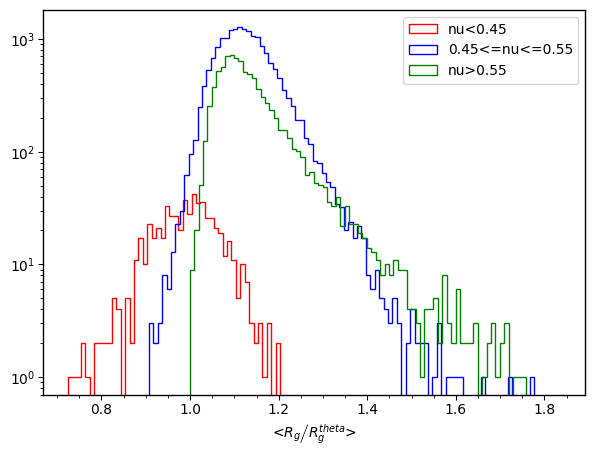

In [96]:

fig,ax = plt.subplots(figsize=(7,5))


ax.hist(seq_name_AFRC[seq_name_AFRC['nu']<0.45]['rg_rg_theta_mean'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[seq_name_AFRC['nu']<0.45]['rg_rg_theta_mean'].min(),
                           seq_name_AFRC[seq_name_AFRC['nu']<0.45]['rg_rg_theta_mean'].max(),0.01),color='red',label='nu<0.45')
               
ax.hist(seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['rg_rg_theta_mean'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['rg_rg_theta_mean'].min(),
                           seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['rg_rg_theta_mean'].max(),0.01),
        color='blue',label='0.45<=nu<=0.55')

ax.hist(seq_name_AFRC[seq_name_AFRC['nu']>0.55]['rg_rg_theta_mean'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[seq_name_AFRC['nu']>0.55]['rg_rg_theta_mean'].min(),
                           seq_name_AFRC[seq_name_AFRC['nu']>0.55]['rg_rg_theta_mean'].max(),0.01),color='green',label='nu>0.55')

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')

ax.legend()
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.set_yscale('log')
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)


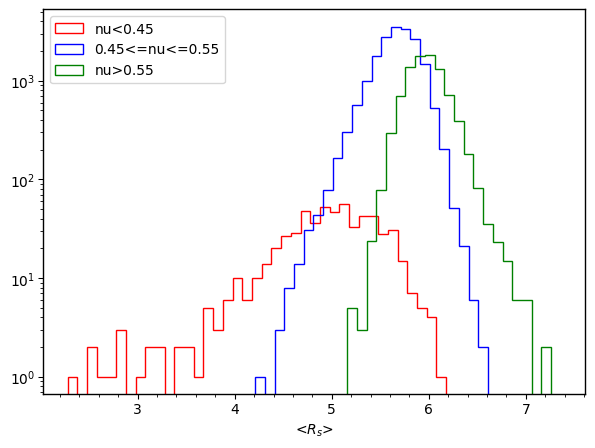

In [95]:

fig,ax = plt.subplots(figsize=(7,5))


ax.hist(seq_name_AFRC[seq_name_AFRC['nu']<0.45]['mean_inst_ratio'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[seq_name_AFRC['nu']<0.45]['mean_inst_ratio'].min(),
                           seq_name_AFRC[seq_name_AFRC['nu']<0.45]['mean_inst_ratio'].max(),0.1),color='red',label='nu<0.45')
               
ax.hist(seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['mean_inst_ratio'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['mean_inst_ratio'].min(),
                           seq_name_AFRC[(seq_name_AFRC['nu']>=0.45) & (seq_name_AFRC['nu']<=0.55)]['mean_inst_ratio'].max(),0.1),
        color='blue',label='0.45<=nu<=0.55')

ax.hist(seq_name_AFRC[seq_name_AFRC['nu']>0.55]['mean_inst_ratio'].values,histtype='step',
           bins = np.arange(seq_name_AFRC[seq_name_AFRC['nu']>0.55]['mean_inst_ratio'].min(),
                           seq_name_AFRC[seq_name_AFRC['nu']>0.55]['mean_inst_ratio'].max(),0.1),color='green',label='nu>0.55')

ax.set_xlabel('<$R_s$>')

ax.legend()
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.set_yscale('log')
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)


In [33]:
#compact_IDRs = seq_name_AFRC[(seq_name_AFRC.rg_rg_theta_mean<0.8) & (seq_name_AFRC.mean_inst_ratio<5) & (seq_name_AFRC.mean_RSA<0.3)].copy()

compact_IDRs = seq_name_AFRC[seq_name_AFRC.nu<0.45]
compact_IDRs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr,AFRC_mean_rg_theta,rg_rg_theta_mean,mean_inst_ratio,mean_RSA,fP
65,A0A1B0GTS1_188_333,A0A1B0GTS1,146,0.378,9.972006,4.988762,0.787314,0.192330,2.929791,5.831316,...,0.000000,0.971541,0.000000,0.416,10.020,30.188069,0.969117,4.235784,0.312731,0.075342
120,A0A1B0GWH4_188_333,A0A1B0GWH4,146,0.400,10.040684,5.203526,0.761809,0.184653,2.954420,5.950467,...,0.000000,0.971541,0.000000,0.416,10.020,30.188069,0.979056,4.334719,0.316796,0.075342
139,A0A286YF58_259_385,A0A286YF58,127,0.437,9.993926,5.781407,0.786543,0.193296,2.752863,6.235752,...,0.559518,0.818483,0.000000,0.433,10.029,28.185389,0.976237,5.483694,0.338801,0.118110
171,A0AVI2_1927_2057,A0AVI2,131,0.436,9.989349,5.538025,0.766125,0.186892,2.872842,6.345160,...,0.000000,-0.924200,0.152672,0.480,9.964,28.715327,0.998992,5.132985,0.335606,0.122137
196,A0PJX2_1_45,A0PJX2,45,0.359,10.333192,5.014966,0.884950,0.206612,1.617302,3.401713,...,3.086776,0.075373,0.000000,0.499,10.331,16.768636,0.964710,4.642840,0.403596,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27659,Q9Y5B9_917_1047,Q9Y5B9,131,0.273,10.187119,4.268372,0.726670,0.181412,2.836427,5.510589,...,5.069440,0.000000,0.000000,0.509,10.212,28.610869,0.990361,4.077155,0.365211,0.030534
27743,Q9Y5J1_1_221,Q9Y5J1,221,0.276,9.965369,3.825809,0.697702,0.174628,3.328500,5.810269,...,4.819276,0.951653,0.000000,0.327,10.056,37.269856,0.891906,3.411702,0.296724,0.085973
27770,Q9Y5Q8_460_519,Q9Y5Q8,60,0.436,10.486637,5.025007,0.941976,0.242315,2.238565,4.800477,...,5.783474,0.000000,0.000000,0.537,10.474,19.353188,1.156485,4.751992,0.471442,0.033333
27950,Q9Y6J9_373_622,Q9Y6J9,250,0.441,9.878319,5.298911,0.798289,0.191471,4.176723,9.030963,...,0.000000,2.565562,0.000000,0.487,9.920,39.461072,1.057901,4.907357,0.355628,0.136000


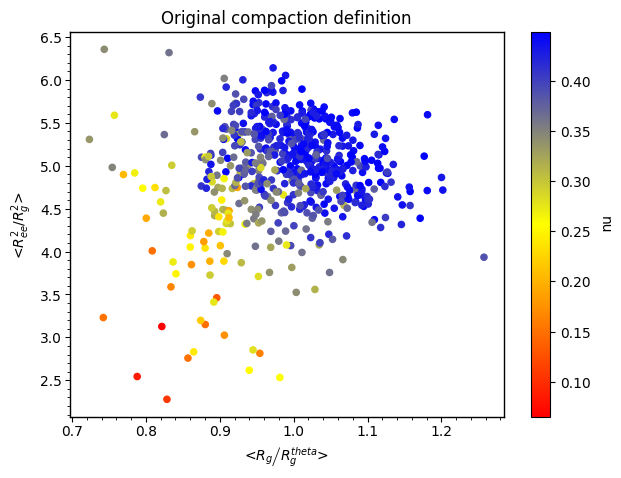

In [38]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
ax.set_title('Original compaction definition')
sc = ax.scatter(compact_IDRs['rg_rg_theta_mean'],
           compact_IDRs['mean_inst_ratio'],s=20,c=compact_IDRs['nu'].values,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('nu',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

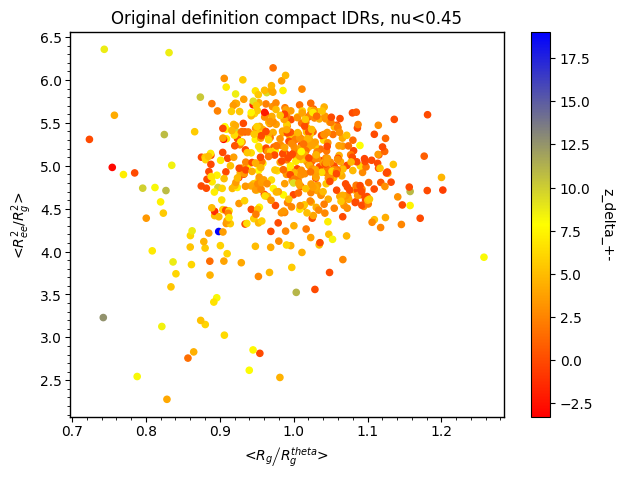

In [37]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(compact_IDRs['rg_rg_theta_mean'],
           compact_IDRs['mean_inst_ratio'],s=20,c=compact_IDRs['z_delta_+-'].values,cmap=palette)
               
ax.set_title('Original definition compact IDRs, nu<0.45')           
cbar = plt.colorbar(sc)
cbar.set_label('z_delta_+-',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

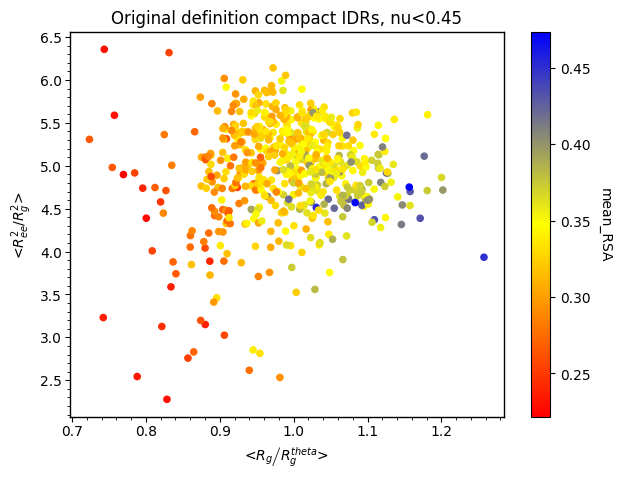

In [180]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(compact_IDRs['rg_rg_theta_mean'],
           compact_IDRs['mean_inst_ratio'],s=20,c=compact_IDRs['mean_RSA'].values,cmap=palette)
               
ax.set_title('Original definition compact IDRs, nu<0.45')           
cbar = plt.colorbar(sc)
cbar.set_label('mean_RSA',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

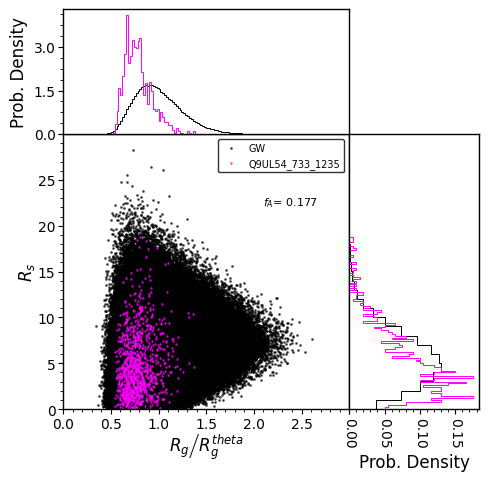

In [169]:
compute_3dplot_from_seq_name('Q9UL54_733_1235')

100000 GW snapshots completed
200000 GW snapshots completed
300000 GW snapshots completed
400000 GW snapshots completed
500000 GW snapshots completed
600000 GW snapshots completed
700000 GW snapshots completed
800000 GW snapshots completed
900000 GW snapshots completed
1000000 GW snapshots completed


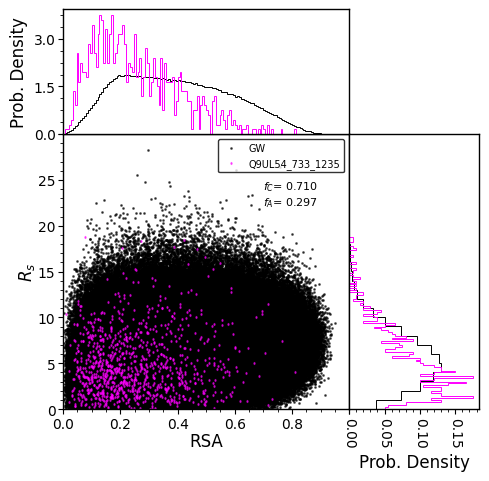

In [170]:
RSA_Rs_compute_3dplot_from_seq_name('Q9UL54_733_1235')

# extended IDRs

In [173]:
extended_IDRs = seq_name_AFRC[seq_name_AFRC.nu>0.55]
extended_IDRs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,z_omega_+,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr,AFRC_mean_rg_theta,rg_rg_theta_mean,mean_inst_ratio,mean_RSA
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,0.000000,0.000000,-0.531910,0.000000,0.565,10.288,15.191941,1.057621,5.808555,0.442952
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,1.947253,0.000000,0.090132,0.369565,0.578,10.316,17.085913,1.100872,6.130355,0.438200
13,A0A087X179_1_50,A0A087X179,50,0.553,10.210735,6.410563,0.911987,0.209899,1.938378,4.694690,...,-0.005733,0.419587,2.156226,0.000000,0.543,10.234,17.677805,1.096507,6.017042,0.422276
18,A0A096LP01_37_95,A0A096LP01,59,0.553,10.209653,6.481172,0.873620,0.230349,2.141679,5.218189,...,-0.842906,-0.661841,0.000673,0.000000,0.555,10.234,19.154261,1.117824,6.124207,0.431812
23,A0A0A6YYL3_331_461,A0A0A6YYL3,131,0.567,10.204387,6.387528,0.981006,0.217707,3.585452,8.660681,...,1.026741,0.499326,0.243779,0.000000,0.556,10.228,28.571497,1.255998,6.013736,0.434446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28039,Q9Y6X8_143_267,Q9Y6X8,125,0.551,10.113270,6.162259,0.943287,0.234397,3.385519,8.016094,...,1.770782,0.667217,0.310603,0.000000,0.535,10.139,27.890835,1.215358,5.793962,0.435524
28040,Q9Y6X8_508_537,Q9Y6X8,30,0.594,10.365444,6.791555,0.925280,0.221354,1.455903,3.635586,...,1.026538,0.000000,0.000000,0.000000,0.568,10.327,13.768522,1.057118,6.337872,0.446577
28041,Q9Y6X9_843_911,Q9Y6X9,69,0.586,10.413533,6.421808,0.996853,0.236383,2.590618,6.316464,...,0.000000,-0.475761,0.048782,0.000000,0.579,10.331,20.741268,1.247579,6.064757,0.461396
28049,Q9Y6Y8_595_653,Q9Y6Y8,59,0.556,10.365497,6.295936,0.909705,0.223937,2.264625,5.434083,...,-1.785758,0.038545,-1.050328,0.000000,0.560,10.274,19.185888,1.182662,5.914221,0.433642


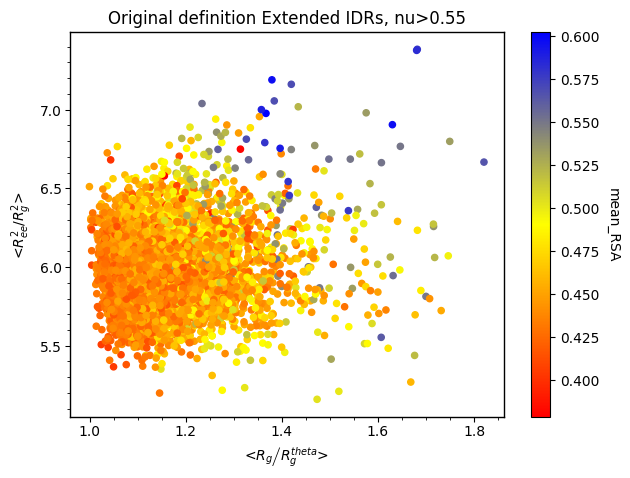

In [177]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(extended_IDRs['rg_rg_theta_mean'],
           extended_IDRs['mean_inst_ratio'],s=20,c=extended_IDRs['mean_RSA'].values,cmap=palette)
               
ax.set_title('Original definition Extended IDRs, nu>0.55')                      
cbar = plt.colorbar(sc)
cbar.set_label('mean_RSA',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

# Mid IDRs

In [181]:
mid_IDRs = seq_name_AFRC[(seq_name_AFRC.nu<=0.55) & (seq_name_AFRC.nu>=0.45)]
mid_IDRs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,z_omega_+,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr,AFRC_mean_rg_theta,rg_rg_theta_mean,mean_inst_ratio,mean_RSA
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,-0.043142,0.000000,0.061436,0.000000,0.532,10.107,14.102458,1.026155,5.598546,0.408551
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,0.384885,2.281943,1.092688,0.298507,0.537,10.167,20.524202,1.094369,5.764964,0.403545
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,0.799692,0.000000,0.627563,0.000000,0.509,10.018,28.732651,1.057445,5.766837,0.365432
5,A0A087WVF3_214_549,A0A087WVF3,336,0.480,9.934009,5.852594,0.901346,0.207319,4.955995,11.307038,...,0.102133,0.000000,0.545020,0.235119,0.485,9.933,45.774187,1.086784,5.484203,0.378449
6,A0A087WVF3_1_53,A0A087WVF3,53,0.545,10.232646,6.338211,0.892725,0.215840,2.012452,4.855736,...,0.161207,0.616683,2.680513,0.000000,0.543,10.221,18.205241,1.104360,5.976713,0.415439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,-1.319891,0.000000,0.163169,0.000000,0.520,9.993,33.590806,1.128366,5.388851,0.391268
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,-2.182869,0.000000,2.214949,0.000000,0.537,9.984,39.658059,1.156510,5.803936,0.394400
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,0.451957,2.132808,1.114749,0.513761,0.513,10.072,25.880343,1.164103,5.738483,0.426205
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,0.554013,2.234693,-1.942090,0.451327,0.512,10.063,26.561695,1.108354,5.813349,0.400844


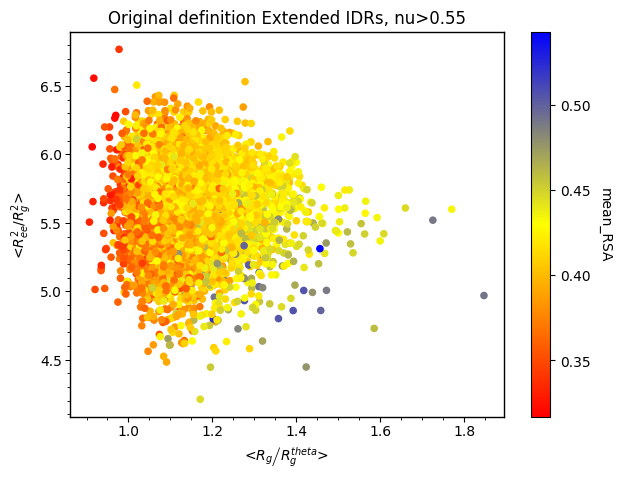

In [182]:

fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(mid_IDRs['rg_rg_theta_mean'],
           mid_IDRs['mean_inst_ratio'],s=20,c=mid_IDRs['mean_RSA'].values,cmap=palette)
               
ax.set_title('Original definition Extended IDRs, nu>0.55')                      
cbar = plt.colorbar(sc)
cbar.set_label('mean_RSA',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)